# Results report

We use this notebook to store the results of the multiple benchmarks that were run on the algorithms implemented. Details will be added alongside the tests results.

In [1]:
# Execute this cell first if you want to run the tests
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

from project.policy import (
    RandomPolicy, VIPolicy, EpsilonVIPolicy, UCBPolicy
)
from project.oracle import Oracle
from project.bandit import Bandit, BernouilliArm

The cell below is used to define the benchmark being run.

In [4]:
# Policies definitions
policy_names = (
    'random',
    'VI',
    'epsVI',
    'UCB_0.2',
    'UCB_2',
    'UCB_20',
)
policy_objects = (
    RandomPolicy(),
    VIPolicy(),
    EpsilonVIPolicy(),
    UCBPolicy(delta=0.2),
    UCBPolicy(delta=2),
    UCBPolicy(delta=20)
)
policies = dict(zip(policy_names, policy_objects))

# Bandits definition
null_bandit = Bandit.generate(
    arm_class=BernouilliArm,
    arm_kwargs=(
        {'p': 0.3},
        {'p': 0.3},
    )
)

alt_bandit = Bandit.generate(
    arm_class=BernouilliArm,
    arm_kwargs=(
        {'p': 0.3},
        {'p': 0.5},
    )
)

# Construct Oracle
oracle = Oracle(policies=policies.values())

The following cell will run both simulations for the null and the alternative hypotheses.

In [5]:
# Benchmark definition
n_runs = int(1e4)
n_steps = 148
seed = None  # set a seed for reproducible results

# Store results for both hypotheses simulations
oracle.set_bandit(null_bandit)
null_report = oracle.evaluate(
    n_runs=n_runs,
    run_length=n_steps,
    seed=seed
)
oracle.set_bandit(alt_bandit)
alt_report = oracle.evaluate(
    n_runs=n_runs,
    run_length=n_steps,
    seed=seed
)

In [6]:
# Small utility for plotting results from both reports
def _plot(plot_fun, index):
    if isinstance(index, int):
        indices = [index]
    else:
        indices = list(index)
    
    for _idx in indices:
        pname = policy_names[_idx]
        plot_fun(null_report, _idx, label='H0-{}'.format(pname))
        plot_fun(alt_report, _idx, label='H1-{}'.format(pname))
    
    plt.legend()

# And a utility to get the index of a policy by name
def _index(policy_name):
    return policy_names.index(policy_name)

---

In [16]:
# Set-up the policies of interest to compare
pindex = [_index(name) for name in ('UCB_0.2', 'UCB_2', 'UCB_20')]# 'VI', 'epsVI')]

## Reward and regret

We first consider the following metrics of performance:

- **Expected Total Discounted**, or **ETD**, as used in the article:

$$\sum_t \sum_k d^t r_{k,t} a_{k,t}$$

- **Expected Reward** at a given timestep $t$, and its cumulative sum, the **Expected Number of Successes** (ENS)
- **Expected Total Regret** (where $p_{k^*}$ is the best arm's probability of success, and $r_t = \sum_k r_{k,t} a_{k,t}$):

$$T \cdot p_{k^*} - \sum_t r_t$$

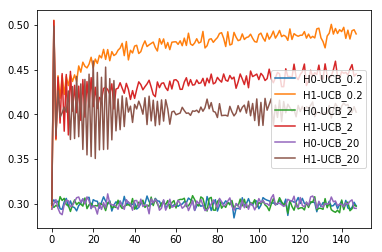

In [17]:
# Expected Reward at time t
def plot_exp_reward(report, index, **kwargs):
    observed_rewards = report.results[:, index, :]
    expected_reward = np.mean(observed_rewards, axis=0)

    plt.plot(expected_reward, **kwargs)


_plot(plot_exp_reward, pindex)

In [18]:
# Expected Number of Successes at final timestep
def print_ens(report, index, report_name=None):
    obs = report.results[:, index, :]
    ns = np.sum(obs, axis=1)
    ens = np.mean(ns)
    ens_se = np.std(ns)

    print(
        '({policy}) ENS {hypothesis}= {ens:.2f} ({std:.2f})'.format(
            policy=policy_names[index], ens=ens, std=ens_se,
            hypothesis='' if report_name is None else '({}) '.format(
                report_name
            )
        )
    )

for idx in pindex:
    print_ens(null_report, idx, 'H0')
    print_ens(alt_report, idx, 'H1')

(UCB_0.2) ENS (H0) = 44.41 (5.58)
(UCB_0.2) ENS (H1) = 70.43 (8.16)
(UCB_2) ENS (H0) = 44.28 (5.62)
(UCB_2) ENS (H1) = 64.23 (6.38)
(UCB_20) ENS (H0) = 44.36 (5.55)
(UCB_20) ENS (H1) = 59.82 (5.89)


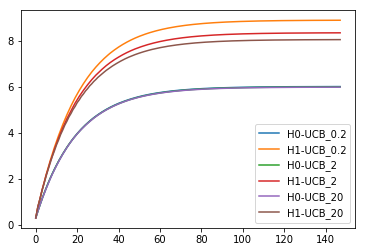

In [19]:
# Expected Total Discounted reward at time t

# Set discount value here
discount = 0.95

def plot_etd(report, index, **kwargs):
    obs = report.results[:, index, :]
    exp = np.mean(obs, axis=0)
    etd = np.cumsum([
        discount ** t * exp[t]
        for t in range(n_steps)
    ])

    plt.plot(etd, **kwargs)

_plot(plot_etd, pindex)

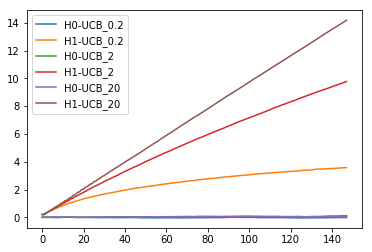

In [20]:
# Expected Total Regret at time t

def plot_etr(report, index, **kwargs):
    obs = report.results[:, index, :]
    exp = np.mean(obs, axis=0)
    
    best_arm = max(arm.p for arm in report.bandit.arms)
    etr = np.cumsum(best_arm - exp)

    plt.plot(etr, **kwargs)

_plot(plot_etr, pindex)

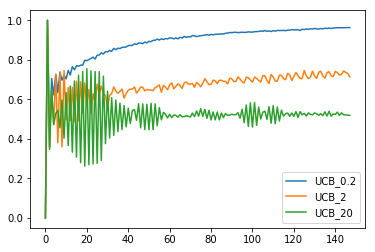

In [21]:
# Probability of selecting the best arm

def plot_prob_best_arm(report, index, **kwargs):
    actions = report.actions[:, index, :]
    
    best_arm = np.argmax([arm.p for arm in report.bandit.arms])
    prob = np.mean(actions == best_arm, axis=0)
    
    plt.plot(prob, **kwargs)

for idx in pindex:
    plot_prob_best_arm(alt_report, idx, label=policy_names[idx])

plt.legend()

In [22]:
# Expected proportion of correctly assigned patients

def print_exp_accuracy(report, index, **kwargs):
    actions = report.actions[:, index, :]
    
    best_arm = np.argmax([arm.p for arm in report.bandit.arms])
    prob = np.mean(actions == best_arm)
    
    print(
        '({1} {0}) p* = {2:.3f}'.format(
            kwargs.get('hypothesis', ''), policy_names[index], prob)
    )

for idx in pindex:
    print_exp_accuracy(null_report, idx, hypothesis='H0')
    print_exp_accuracy(alt_report, idx, hypothesis='H1')

(UCB_0.2 H0) p* = 0.497
(UCB_0.2 H1) p* = 0.886
(UCB_2 H0) p* = 0.500
(UCB_2 H1) p* = 0.666
(UCB_20 H0) p* = 0.500
(UCB_20 H1) p* = 0.518
